`Yuxiang Wang ` | `Zixun Zheng `

# Final project of Introduction to Machine Learning (EL-GY 9123)

Since **Ebola Virus** busted out to be a super threat to the human being in all over the world, we have a concern about the future of our life. The undergoing medical research may also be assisted by the prediction of the virus spreading. In our project, we conducted a simple but dedicated approach to predict the virus versus the temperature of the locations/ countries that have reported confirmed Ebola cases. 
The following are the basic steps to run the project in this notebook

1. Load data source 
2. Cleanse data format and extract data
3. Test data using different models
4. Data visualization
		

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline

In [69]:
names = ['Indicator','Country','Date','value']
df = pd.read_csv('https://ds-ec2.scraperwiki.com/g7nnqgn/ckm9nsfssakeuor/cgi-bin/csv/ebola_data_db_format.csv',
                names=names,na_values='?',header=None,skiprows=1)
df = df.dropna()
df.head(6)

,Indicator,Country,Date,value
0,"Cumulative number of confirmed, probable and s...",Guinea,2015-03-10,3285.0
1,Cumulative number of confirmed Ebola cases,Guinea,2015-03-10,2871.0
2,Cumulative number of probable Ebola cases,Guinea,2015-03-10,392.0
3,Cumulative number of suspected Ebola cases,Guinea,2015-03-10,22.0
4,"Cumulative number of confirmed, probable and s...",Guinea,2015-03-10,2170.0
5,Cumulative number of confirmed Ebola deaths,Guinea,2015-03-10,1778.0


## 1. Take a look at the data
in this data set `ebola_data_db_format.csv`, we have the statistics of `comfirmed` as `c`,`suspected` as `s`,`probable` as `p`,`deaths` as `d`.
in the csv we have find in the 1st column, there are 
1. `cps` case
2. `c` case
3. `p` case
4. `s` case
where the number of `c` + `p` + `c` = `cps`

and,
1. `cps` death
2. `c` death
3. `p` death
where the number of `c` + `p` = `cps`

In our project we will computed the the ratio of comfirmed Ebola reports as `y`

In [70]:
df['Country'].unique()
# we need to select data only stable not recently updated
# (Liberia 2 is a indicator that shows recently updated data), do not need to consider
# leave it for later processing

array(['Guinea', 'Liberia', 'Sierra Leone', 'United Kingdom', 'Mali',
       'Nigeria', 'Senegal', 'Spain', 'United States of America', 'Italy',
       'Liberia 2', 'Guinea 2'], dtype=object)

In [499]:
# Fetch weather data from the following authorized websites
# www.holiday-weather.com
# www.currentresults.com/Weather/US
# www.nationsencyclopedia.com
# www.weather-and-climate.com

T_Guinea=[73.0,84.0,78.5]
T_Liberia=[81.0,81.0,81.0]
T_Sierra_Leone=[78.6,83.3,80.95]
T_United_Kingdom=[40.0,60.0,50.0]
T_Mali=[77.2,90.3,83.75]
T_Nigeria=[78.8,82.4,80.6]
T_Senegal=[70.0,82.0,76.0]
T_Spain=[46.0,73.0,59.5]
T_United_States_of_America=[33.2,71.9,52.55]
T_Italy=[46.0,78.0,62.0]

In [86]:
T = [T_Guinea, T_Italy, T_Liberia, T_Mali, T_Nigeria, T_Senegal,
     T_Sierra_Leone, T_Spain, T_United_Kingdom, T_United_States_of_America]

In [90]:
T[0][0]

73.0

In [128]:
# split df, choose first 0~9947 rows as stable data
ntotal = 9947
ntr = 8000
nts = ntotal - ntr
df_tot = df.loc[0:ntotal,:]

## 2. Preprocessing
Use annual average temperature to represent the country

$$
X = [Country, Date] \to [avg_{Temperature}, Date] \\
y1 = percentage of comfirmed disease reports \\ 
y2 = percentage of comfirmed death reports
$$

In [129]:
# extract date from dataframe
x_df = df_tot.loc[df['Indicator'] == 'Cumulative number of confirmed, probable and suspected Ebola cases'
                   , ['Country', 'Date', 'value']]

In [191]:
# construct training data X[country, date]
# convert the country and date column to numpy array
x_df_country = x_df.take([0], axis=1)
x_df_date = x_df.take([1], axis=1)

x_country = x_df_country.values
x_date = x_df_date.values

# parse date to "day of year" numerical
x_date = x_date.ravel()
x_days = pd.to_datetime(x_date, format= "%Y-%m-%d").dayofyear.values
x_country = x_country.ravel()

In [131]:
# extract the confirmed ebola cases
ls = []

for i in range(x_date.shape[0]):
    ls.append(df_tot.loc[(df['Date'] == x_date[i]) & 
                        (df['Country'] == x_country[i]) & 
                        (df['Indicator'] == 'Cumulative number of confirmed Ebola cases'),
                        ['value']].take([0], axis=1).values)

In [132]:
# convert cd list to numpy array of float elements
cd_arr = np.array(ls)
for i in range(len(cd_arr)):
    if cd_arr[i].ravel().size == 0:
        cd_arr[i] = float(0.0)
    try:
        cd_arr[i] = cd_arr[i].ravel()[0]
    except:
        continue

In [133]:
# get the total ebola cases 
totd_arr = x_df.take([2], axis=1).values
totd_arr = totd_arr.ravel()

In [134]:
# Compute the percentage of comfirmed ebola ratio

# first fix invalid fields
invalid_fields = np.where(totd_arr == 0)[0]
totd_arr[invalid_fields] = (1, 1)
cd_arr[invalid_fields] = (0, 0)

cd_ratio = cd_arr / totd_arr # this is the array of percentage of cd (confirmed disease)

In [151]:
y = cd_ratio

In [214]:
# create three arrays ready to be replaced by lowest temperature,
#  highest temperature and average temperature
x_lo_T = np.array([i for i in x_country])
x_hi_T = np.array([i for i in x_country])
x_avg_T = np.array([i for i in x_country])

In [215]:
# replace each array by corresponding values for theirs temperature type
nCountry = len(np.unique(x_country))
# For the sake of readability, I seperate three loops instead of include them under a outler loop
# lowest T
for c in range (nCountry):
    np.place(x_lo_T, x_lo_T == np.unique(x_country)[c], T[c][0])
# highest T
for c in range (nCountry):
    np.place(x_hi_T, x_hi_T == np.unique(x_country)[c], T[c][1])
# average T
for c in range (nCountry):
    np.place(x_avg_T, x_avg_T == np.unique(x_country)[c], T[c][2])            

array(['73.0', '81.0', '78.6', ..., '78.6', '81.0', '73.0'],
      dtype='<U24')

In [481]:
X = np.row_stack([xtr_lo_T, xtr_hi_T, xtr_avg_T, x_days]).T
X = X.astype(float)

# normalization
X = X/np.max(X,axis=1)[:,None]
X.shape

(1324, 4)

## 3. Linear model
Linear model can explain most physical phenomenan, so we choose it for first view at this problem.

First, we import linear_model and use first 80% of data for trainning and the rest for test.

In [482]:
from sklearn import linear_model

ntr = int(np.floor(0.8*X.shape[0]))
xtr = X[:ntr,:]
ytr = y[:ntr]
xts = X[ntr:, :]
yts = y[ntr:]

regr = linear_model.LinearRegression()
regr.fit(xtr,ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

After fitting the linear model, we predict it using test data.

In [495]:
y_pred = regr.predict(xts)

In another way, we use matrix computation to create a linear model and predict for test data.

In [496]:
# Assume countries and days are correlated
Xtr = np.column_stack((np.ones(ntr),xtr[:,0],xtr[:,1],xtr[:,2],xtr[:,3]))
Xts = np.column_stack((np.ones(xts.shape[0]),xts[:,0],xts[:,1],xts[:,2],xts[:,3]))

# Compute weight matrix
W1 = ytr[None,:,None]/Xtr[None,:,:]
W1 = np.mean(W1,axis=1)

y_pred1 = W1*Xts

Plot `y_pred` vs `yts`, the red line indicates that `y_pred`=`yts`.

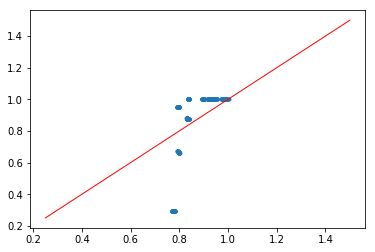

In [497]:
plt.plot(y_pred,yts,'.')
plt.plot([0.25,1.5], [0.25,1.5], 'r-', linewidth=1)

We can see the dots locate around the "great-fitting" line.

## 4. Quadratic model
Then, we use 2nd-order(quadratic) model to solve this problem.

First, formulate matrix as Xtr=[1,xtr[0],xtr[0]^2,...,xtr[n],xtr[n]^2]. We assume that each factor is uncorrelated to each other.

In [486]:
n = 2 # 2-nd order

# Assume countries and days are correlated
Xtr = np.column_stack((np.ones(xtr.shape[0]),xtr[:,0],xtr[:,0]**2,xtr[:,1],
                       xtr[:,1]**2,xtr[:,2],xtr[:,2]**2,xtr[:,3],xtr[:,3]**2))
Xts = np.column_stack((np.ones(xts.shape[0]),xts[:,0],xts[:,0]**2,xts[:,1],
                       xts[:,1]**2,xts[:,2],xts[:,2]**2,xts[:,3],xts[:,3]**2))

# Compute weight matrix
W2 = ytr[None,:,None]/Xtr[None,:,:]
W2 = np.mean(W2,axis=1)

y_pred2 = W2*Xts

After trainning, we predict and plot `y_pred` vs `yts`. We can see it is better than linear model.

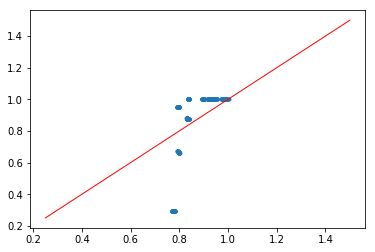

In [487]:
plt.plot(y_pred,yts,'.')
plt.plot([0.25,1.5], [0.25,1.5], 'r-', linewidth=1)

## 5. Order selection
Find a proper model order in range `N=10`.

Create matrixs of each factor to perserve its each order.

In [498]:
N = 10  # order

Xtr_lt = np.zeros((N,xtr.shape[0],1))
Xtr_ht = np.zeros((N,xtr.shape[0],1))
Xtr_at = np.zeros((N,xtr.shape[0],1))
Xtr_day = np.zeros((N,xtr.shape[0],1))
Xts_lt = np.zeros((N,xts.shape[0],1))
Xts_ht = np.zeros((N,xts.shape[0],1))
Xts_at = np.zeros((N,xts.shape[0],1))
Xts_day = np.zeros((N,xts.shape[0],1))

for i in range(N):
    for m in range(xtr.shape[0]):
        
        Xtr_lt[i][m] = xtr[m,0]**i
        Xtr_ht[i][m] = xtr[m,1]**i
        Xtr_at[i][m] = xtr[m,2]**i
        Xtr_day[i][m] = xtr[m,3]**i
        
    for n in range(xts.shape[0]):
        
        Xts_lt[i][n] = xts[n,0]**i
        Xts_ht[i][n] = xts[n,1]**i
        Xts_at[i][n] = xts[n,2]**i
        Xts_day[i][n] = xts[n,3]**i
    


Column stack the factors into two matrixs, `Xtr_res` and `Xts_res`.

In [490]:
Xtr_res = []
Xts_res = []
Xtr_t_name = [Xtr_lt, Xtr_ht, Xtr_at, Xtr_day]
Xts_t_name = [Xts_lt, Xts_ht, Xts_at, Xts_day]
for t in range(4):
    cur_tr = Xtr_t_name[t]
    cur_ts = Xts_t_name[t]
    newtr = []
    newts = []
    for n in range(N):
        curtr = np.array([])
        curtr = np.append(curtr, cur_tr[n])
        newtr.append(curtr)
        
        curts = np.array([])
        curts = np.append(curts, cur_ts[n])
        newts.append(curts)
    Xtr_res.append(newtr)
    Xts_res.append(newts)

Train the model and predict for each order.

In [492]:
Xtr = np.array(Xtr_res)
Xts = np.array(Xts_res)
y_pred = []
w = []

# Compute weight matrix
for n in range(1, N):
    for j in range(n):
        X_tr = np.ones((xtr.shape[0],4*n+1))
        if j == 0:
            X_tr[:,0] = Xtr[0,j,:]
        else:
            X_tr[:,4*j-3] = Xtr[0,j,:]
            X_tr[:,4*j-2] = Xtr[1,j,:]
            X_tr[:,4*j-1] = Xtr[2,j,:]
            X_tr[:,4*j] = Xtr[3,j,:]
        
        X_ts = np.ones((xts.shape[0],4*n+1))
        if j == 0:
            X_ts[:,0] = Xts[0,j,:]
        else:
            X_ts[:,4*j-3] = Xts[0,j,:]
            X_ts[:,4*j-2] = Xts[1,j,:]
            X_ts[:,4*j-1] = Xts[2,j,:]
            X_ts[:,4*j] = Xts[3,j,:]
        
    W = ytr[None,:,None]/X_tr[None,:,:]
    W = np.mean(W,axis=1)
    w.append(W)
    y_pred.append( np.mean(W*X_ts,axis=1))


Plot `y_pred` vs `yts` for each order.

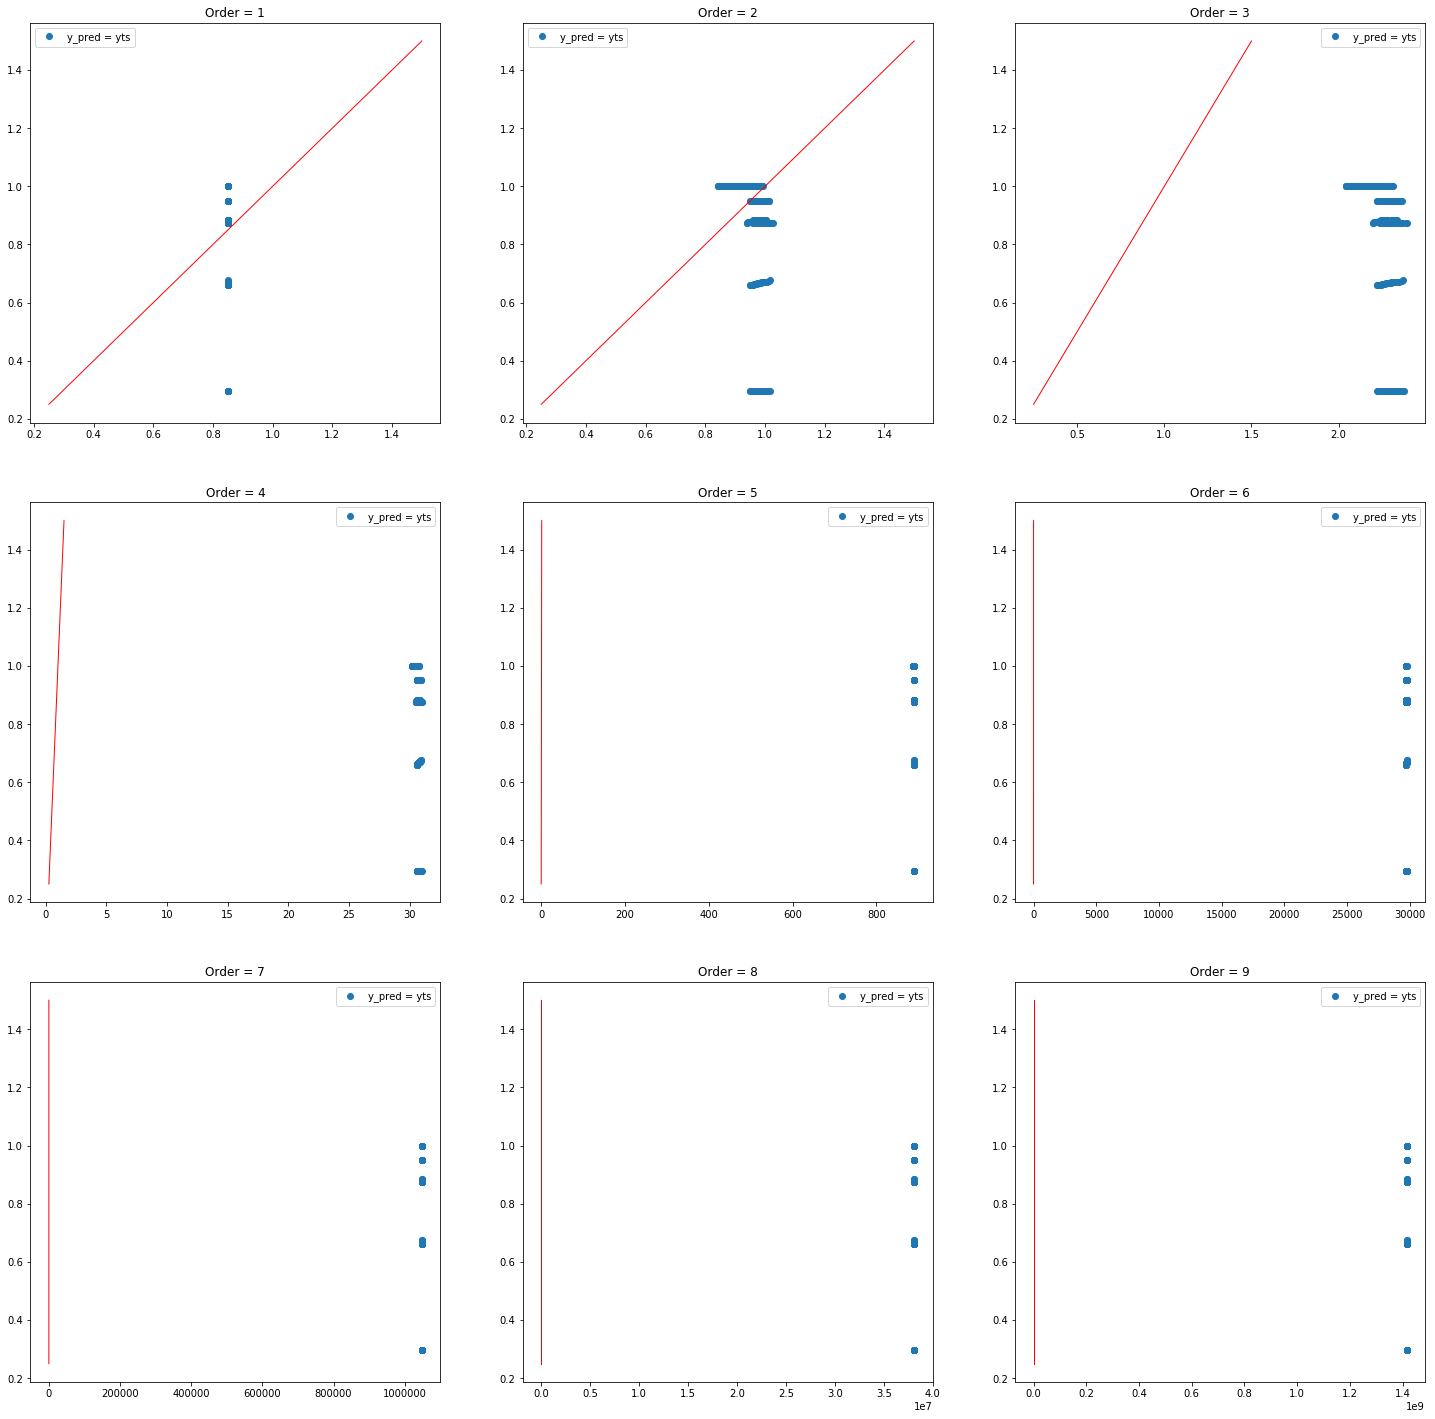

In [494]:
y_pred = np.array(y_pred)

plt.figure(figsize=[25,25])
for i in range(y_pred.shape[0]):
    plt.subplot(3,3,i+1)
    plt.plot(y_pred[i,:],yts,'o')
    plt.plot([0.25,1.5], [0.25,1.5], 'r-', linewidth=1)
    plt.legend(['y_pred = yts'])
    plt.title("Order = {0:d}".format(i+1))

## 5. Conclusion
As we see, second order model fit this situation best. When the order goes higher, the computation complexity increarse but the prediction is poor.

Generally, the Ebola will *very likely to* **spread and burst out** when the **average temperature goes higher** in a country.